### Visualization and Analysis of Geant4 Samples 

This Jupyter notebook will help visualize the Geant4 images created using the CaloGAN dataset, as well as perform simple analysis of physics observables that act as useful benchmarks to evaluate the performance of CaloGAN in simulating Geant4.

The data imported here is an H5 file generated from Geant4 using this repository: https://github.com/DylGit27/HEPCAT_CaloGAN/tree/main

Running Geant4 using the above repo outputs a ROOT file; to convert to images stored in H5, use `convert_uproot.py`. 

The above repo is developed by Dylan Smith and Benjamin Nachman and is based upon the original CaloGAN dataset developed by M. Paganini, L. de Oliveira, and B. Nachman
(original repo: https://github.com/hep-lbdl/CaloGAN/tree/1adb7ab745f038af8b0e56d1396f839dc6435584). 

In [169]:
### Imports ###

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import h5py

In [170]:
### Functions ###

## Define function used for visualizing G4 samples ##
def log_plotter(H, xedges, yedges, aspect='auto'):
    norm=LogNorm()
    fig = plt.figure(figsize=(12, 12))
    ax = fig.add_subplot(132, aspect=aspect)
    X, Y = np.meshgrid(xedges, yedges)
    im = ax.pcolormesh(X, Y, H, norm=norm, shading = 'auto') # Note that log(energy) is plotted
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04, label="log(E)") 
    ax.set_xlabel("${\eta}$ index")
    ax.set_ylabel("${\phi}$ index")
    
## Plot shower width, i.e. the energy-weighted standard deviations of eta/phi ##
def weighted_std(values, weights):
    average = np.average(values, weights=weights)
    variance = np.average((values-average)**2, weights=weights)
    return np.sqrt(variance)

## Splits matrix of cell energies into array with columns [eta_index, phi_index, energy] ##
def vec_maker(x, y, H):
    xv, yv = np.meshgrid(x, y)
    xf=np.ndarray.flatten(xv)
    yf=np.ndarray.flatten(yv)
    ef=np.ndarray.flatten(H)
    coords = np.array([xf,yf,ef]).T
    return coords

In [171]:
### Import h5 file from convert_uproot.py script ###

filename = "/Users/dylansmith/Desktop/test.h5"
g4 = h5py.File(filename, "r")

In [172]:
### Print keys in h5 file ###

print(g4.keys())

<KeysViewHDF5 ['energy', 'layer_0', 'layer_1', 'layer_2', 'overflow']>


In [173]:
### Convert arrays in h5 file to Numpy ###

layer_0 = np.array(g4['layer_0'])
layer_1 = np.array(g4['layer_1'])
layer_2 = np.array(g4['layer_2'])
energy = np.array(g4['energy'])
overflow = np.array(g4['overflow'])

### Print layer shapes ###
print("Layer 0: ", layer_0.shape)
print("Layer 1: ", layer_1.shape)
print("Layer 2: ", layer_2.shape)

Layer 0:  (51, 3, 96)
Layer 1:  (51, 12, 12)
Layer 2:  (51, 12, 6)


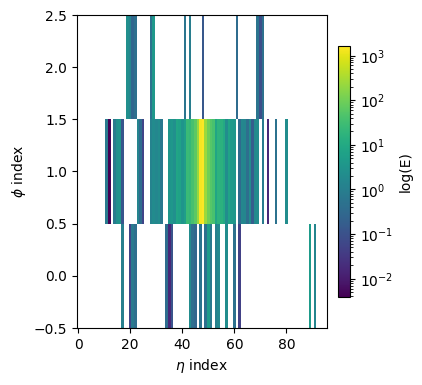

In [174]:
### Print Layer 0 sample ###

sample_0 = layer_0[0]

eta_0 = np.arange(0, sample_0.shape[1])
phi_0 = np.arange(0, sample_0.shape[0])

log_plotter(sample_0, eta_0, phi_0, aspect=40)

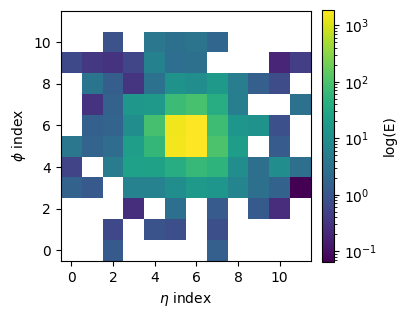

In [175]:
### Print Layer 1 sample ###

sample_1 = layer_1[0]

eta_1 = np.arange(0, sample_1.shape[1])
phi_1 = np.arange(0, sample_1.shape[0])

log_plotter(sample_1, eta_1, phi_1, aspect=1)

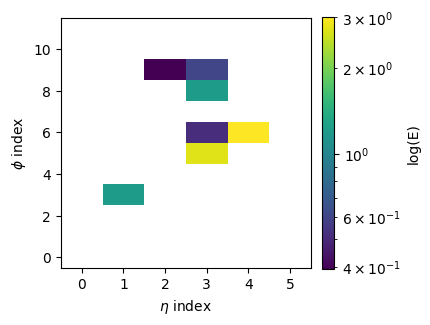

In [176]:
### Print Layer 2 sample ###

sample_2 = layer_2[0]

eta_2 = np.arange(0, sample_2.shape[1])
phi_2 = np.arange(0, sample_2.shape[0])

log_plotter(sample_2, eta_2, phi_2, aspect=0.5)

Next, plot some physics observables. In evaluating how well an ML simulator performs, it is imperative that they reproduce the physics of the Geant4 samples. This is a way to quantify concretely how well the simulator performs, where as "looking" at how similar images are is qualitative (however it is important ML-simulated images look believable in being Geant4 images).

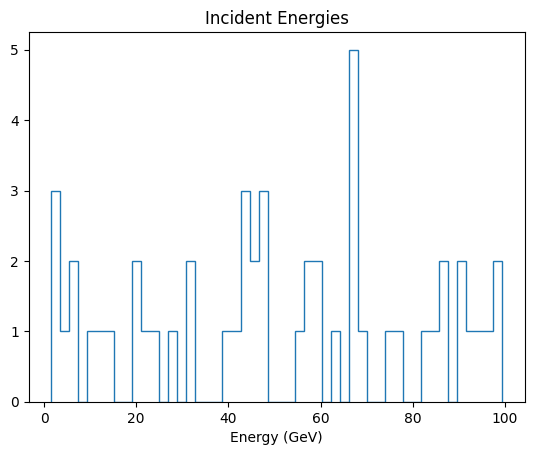

In [177]:
## Start with simply plotting a histogram of all incident energies ##

plt.hist(energy, bins=50, histtype='step')
plt.title("Incident Energies")
plt.xlabel("Energy (GeV)")
plt.show()

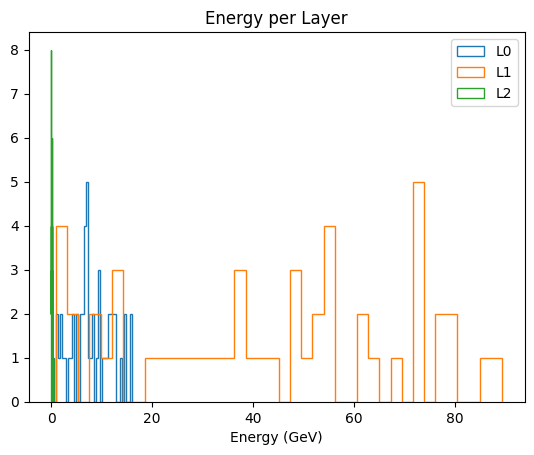

In [178]:
### Plot energy per layer ###

layer0_en = np.sum(layer_0, axis = (1,2))
layer1_en = np.sum(layer_1, axis = (1,2))
layer2_en = np.sum(layer_2, axis = (1,2))

plt.hist(layer0_en/1000, bins = 40, histtype='step', label='L0')
plt.hist(layer1_en/1000, bins = 40, histtype='step', label='L1')
plt.hist(layer2_en/1000, bins = 40, histtype='step', label='L2')
plt.title("Energy per Layer")
plt.xlabel("Energy (GeV)")
plt.legend()
plt.show()

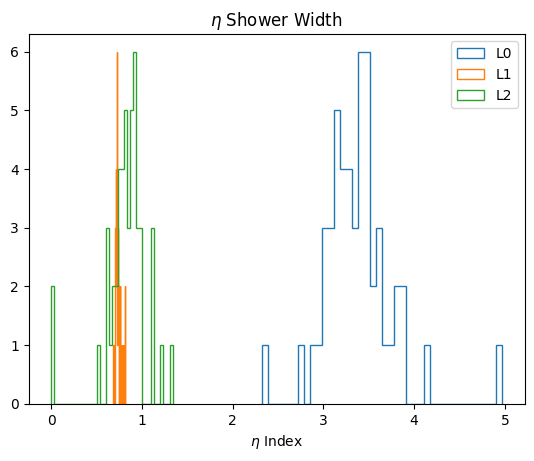

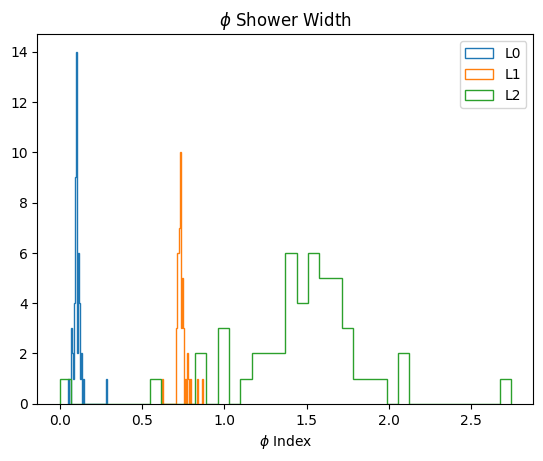

In [179]:
etaWidth0 = []
phiWidth0 = []

etaWidth1 = []
phiWidth1 = []

etaWidth2 = []
phiWidth2 = []

for i in range(len(layer_0)):
    arr0 = vec_maker(eta_0, phi_0, layer_0[i])
    arr1 = vec_maker(eta_1, phi_1, layer_1[i])
    arr2 = vec_maker(eta_2, phi_2, layer_2[i])
    
    etaWidth0.append(weighted_std(arr0[:,0], arr0[:,2]))
    phiWidth0.append(weighted_std(arr0[:,1], arr0[:,2]))
    etaWidth1.append(weighted_std(arr1[:,0], arr1[:,2]))
    phiWidth1.append(weighted_std(arr1[:,1], arr1[:,2]))
    
    if np.sum(arr2[:,2])>0: # Layer 2 is so sparse, some events have zero energy, so these are cut
        etaWidth2.append(weighted_std(arr2[:,0], arr2[:,2]))
        phiWidth2.append(weighted_std(arr2[:,1], arr2[:,2]))
    

### Plot shower width in eta ###
plt.hist(etaWidth0, bins = 40, histtype='step', label='L0')
plt.hist(etaWidth1, bins = 40, histtype='step', label='L1')
plt.hist(etaWidth2, bins = 40, histtype='step', label='L2')
plt.legend()
plt.title("${\eta}$ Shower Width")
plt.xlabel("${\eta}$ Index")
plt.show()

### Plot shower width in phi ###
plt.hist(phiWidth0, bins = 40, histtype='step', label='L0')
plt.hist(phiWidth1, bins = 40, histtype='step', label='L1')
plt.hist(phiWidth2, bins = 40, histtype='step', label='L2')
plt.legend()
plt.title("${\phi}$ Shower Width")
plt.xlabel("${\phi}$ Index")
plt.show()